# Aula 2: Selecionando Métodos e Ajustando Modelos

Francisco Aparecido Rodrigues, francisco@icmc.usp.br.<br>
http://conteudo.icmc.usp.br/pessoas/francisco <br>
Universidade de São Paulo, São Carlos, Brasil.<br>
Copyright (c) 2020.

Nessa aula vamos aprender a ajustar modelos e verificar quando ocorre overfitting. Vamos fazer o ajuste de um conjunto de pontos a partir de um polinômio, usando um método de regressão linear, que veremos em detalhes nas próximas aulas.

Vamos gerar os dados a partir uma função definida:

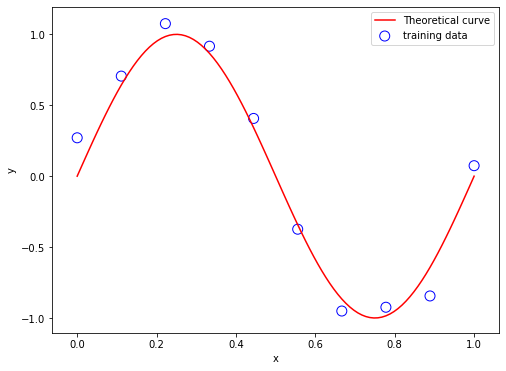

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# definimos uma 'semente' para que os numeros aleatorios sejam previsiveis,
# e portanto, permitindo a reproducibilidade dos experimentos
np.random.seed(101)


# funcao a qual o modelo devera aproximar
def function(x):
    y = np.sin(2 * np.pi * x)
    return y

# numero de amostras para o conjunto de treino
N_train = 10

# gera o conjunto de treino com valores no intervalo 0 e 1
x_train = np.linspace(0, 1, N_train)

# utilizando a funcao real, os valores a serem previstos sao gerados com white noise (ruido)
y_train = function(x_train) + np.random.normal(0, 0.1, N_train)

# O conjunto de teste é criado da mesma forma que os conjunto de treino
N_test = 10
x_test = np.linspace(0, 1, N_test)
y_test = function(x_test) +  np.random.normal(0, 0.1, N_test)

# Visualizacao do ajuste teorico
# Utilizando a funcao original plotamos a curva (vermelho) real
# Note que os valores de treinamento (azul) estao ligeiramente fora da curva real devido ao ruido adicionado
xt = np.linspace(0, 1, 100)
yt = function(xt)

# O codigo abaixo realiza o plot. A função scatter está plotando nosso conjunto de treino (azul). O "plt.plot" está plotando nossa funcao original (vermelha)
fig = plt.figure(figsize=(8, 6))
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=100, label="training data")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(xt,yt, '-r', label="Theoretical curve")
plt.legend()
plt.show(True)

Os dados que temos acesso são os pontos em azul. A curva em vermelho é desconhecida, mas a mostramos para entender como os dados são gerados.

Vamos fazer o ajuste usando um polinômio de grau $M$. Inicialmente, vamos considerar $M=1$, ou seja, um ajuste linear.

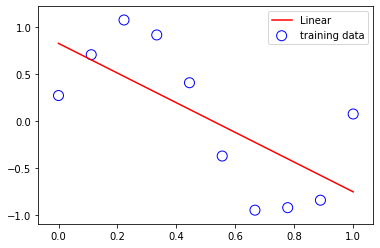

In [2]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

# usa regressão linear para ajustar o modelo
model = linear_model.LinearRegression()
model.fit(x_train.reshape(-1, 1), y_train)

# gera o conjunto de plot e preve os valores de y. OBS: a funcao reshape vai "modelar" nosso vetor para que ele possa ser usado na funcao predict
xplot = np.linspace(0, 1, 200) 
Y_pred = model.predict(xplot.reshape(-1, 1))

# mostra os resultados
plt.plot(xplot, Y_pred, label='Linear', color = 'red')
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=100, label="training data")
plt.legend()
plt.show(True)

Notamos que, nesse caso, o ajuste é muito ruim, pois os dados foram gerados a partir de uma função não-linear.

Vamos fazer o ajuste usando um polinômio de grau $M=3$. Veja a função para gerar o polinômio: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

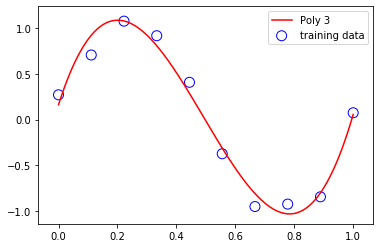

In [3]:
# veja https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it

# Gera uma nova matriz de features consistindo de todas as combinacoes polinomiais das features
#com grau menor ou igual ao especificado
poly3 = PolynomialFeatures(degree=3)
X = poly3.fit_transform(x_train.reshape(-1, 1))

# Treina o modelo linear com das features geradas
model = linear_model.LinearRegression()
model.fit(X, y_train)

# Gera as mesmas features polinomiais no conjunto de plot
Xplot = poly3.fit_transform(xplot.reshape(-1, 1))
Y_pred = model.predict(Xplot)

# Mostra o ajuste feito pelo modelo linear com as novas features polinomiais geradas
plt.plot(xplot, Y_pred, label='Poly 3', color = 'red')
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=100, label="training data")
plt.legend()
plt.show(True)

#### Nesse caso, o ajuste reproduz melhor a tendência observada nos dados.

Vamos verificar para um polinômio de grau $M=9$.

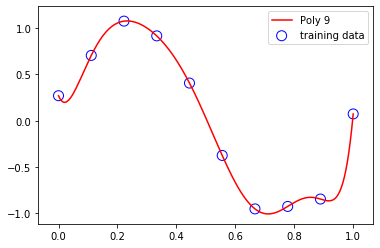

In [4]:
# Gera as features polinomiais de grau 9
poly9 = PolynomialFeatures(degree=9)
X = poly9.fit_transform(x_train.reshape(-1, 1))

model = linear_model.LinearRegression()
model.fit(X,y_train)

Xplot = poly9.fit_transform(xplot[:,np.newaxis])
Y_pred = model.predict(Xplot)

plt.plot(xplot, Y_pred, label='Poly 9', color = 'red')
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=100, label="training data")
plt.legend()
plt.show(True)

Para um polinômio de grau $M=9$, a curva se ajusta a todos os pontos. Em princícipio, esse parece ser o melhor ajuste.

O ajuste foi feito no conjunto de treinamento. Precisamos agora analisar a capacidade de generalização do modelo. Para isso, vamos fazer a previsão em novos dados, ou seja, no conjunto de teste.

Vamos analisar o erro na predição em função do grau do polinômio. O erro é calculando quando consideramos o conjunto de treinamento e teste.

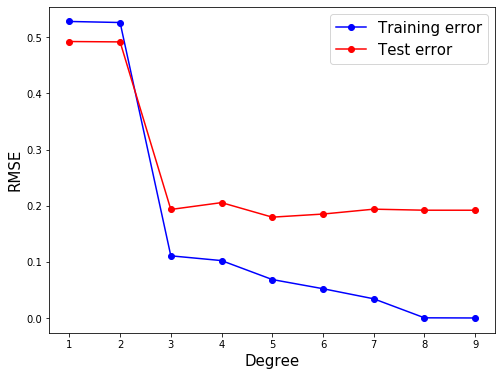

In [5]:
# funcao para o caluclo de erro quadrático médio
def rmse(a, b):
    return np.sqrt(np.mean(np.square(a - b)))

# criamos os vetores para salvar os valores do erro e os graus de polinomio usados
training_errors = []
test_errors = []
degree = []

fig = plt.figure(figsize=(8, 6))

for M in np.arange(1, 10):
    # Gera features polinomiais
    poly = PolynomialFeatures(degree=M) 
    X_train = poly.fit_transform(x_train.reshape(-1, 1))
    
    # Treinamento
    model = linear_model.LinearRegression()
    model.fit(X_train,y_train)
    
    # Calcula nosso erro considerando a base de treino
    Y_pred = model.predict(X_train)
    error_train = rmse(Y_pred, y_train)
    
    training_errors.append(error_train)
    
    # Calcula o erro considerando a base de teste
    X_test = poly.fit_transform(x_test.reshape(-1, 1))
    Y_pred2 = model.predict(X_test)
    
    error_test = rmse(Y_pred2, y_test)
    test_errors.append(error_test)
    
    # Armazena o grau
    degree.append(M)
    

plt.plot(degree, training_errors, 'b-o', label = 'Training error')
plt.plot(degree, test_errors, 'r-o', label= 'Test error')
plt.xlabel("Degree", fontsize = 15)
plt.ylabel("RMSE", fontsize = 15)
plt.legend(fontsize = 15)
plt.show(True)

Notem que o erro na predição, quando usamos o conjunto de teste, tende a aumentar quando aumentamos o grau do polinômio, ou seja, quando aumentamos a complexidade do modelo. Essa é uma indicação de overfitting (veja material da aula teórica). Overfitting ocorre quando há um aumento no erro calculado no conjunto de teste. Notem que o erro no conjunto de treinamento vai a zero quando aumentamos o grau do polinômio. Nesse caso, a curva se ajusta a todos os pontos, como vimos anteriormente para $M = 9$.

Se aumentarmos o número de elementos no conjunto de treinamento, reduzimos o overfitting. Ou seja, precisamos balancear a complexidade do modelo de acordo com o volume de dados disponíveis. Vamos gerar os dados como anteriormente, mas com mais pontos.

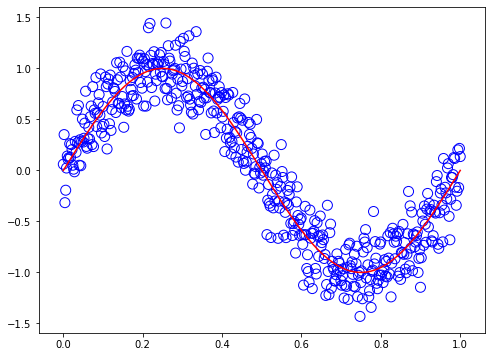

In [6]:
# Dados de treino
N_train = 500
x_train = np.linspace(0, 1, N_train)
y_train = np.sin(2 * np.pi * x_train) + np.random.normal(0, 0.2, N_train)

# Dados de teste
N_test = 500
x_test = np.linspace(0, 1, N_test)
y_test = np.sin(2 * np.pi * x_test) +  np.random.normal(0, 0.2, N_test)

# Curva teorica
xt = np.linspace(0, 1,N_test)
yt = np.sin(2 * np.pi * xt) 

fig = plt.figure(figsize=(8, 6))
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=100, label="training data")
plt.plot(xt,yt, '-r')
plt.show(True)

Para um polinômio de grau $M=9$, vemos que com mais pontos, overfitting deixa de ocorrer.

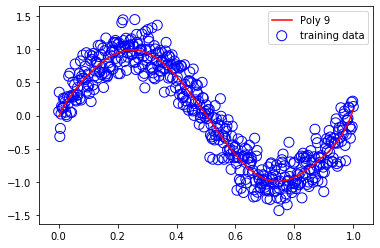

In [7]:
# Novamente, vamos usar as mesmas funcoes para polinomial de grau 9
poly9 = PolynomialFeatures(degree=9)
X = poly9.fit_transform(x_train.reshape(-1, 1))

# Regressao linear
clf9 = linear_model.LinearRegression()
clf9.fit(X,y_train)

Xplot=poly9.fit_transform(xplot.reshape(-1, 1))
Y_pred = clf9.predict(Xplot)
plt.plot(xplot, Y_pred, '-r',  label='Poly 9')
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=100, label="training data")
plt.legend()
plt.show(True)

Podemos até usar polinômios de grau maior. Analisando o erro em função do grau do polinômio, vemos que ocorre overfitting apenas para polinômios de grau muito alto.

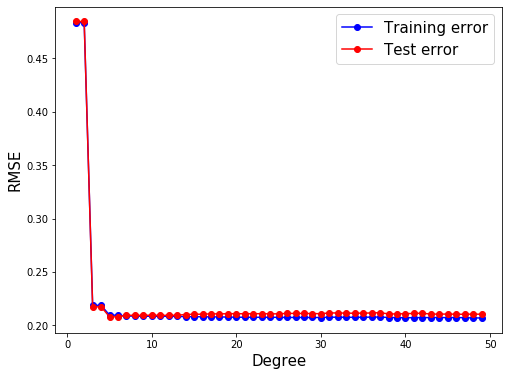

In [8]:
def rmse(a, b):
    return np.sqrt(np.mean(np.square(a - b)))

training_errors = []
test_errors = []
degree = []

for M in np.arange(1, 50):    
    poly = PolynomialFeatures(degree=M)
    X_train = poly.fit_transform(x_train[:,np.newaxis])
    
    clf = linear_model.LinearRegression()
    clf.fit(X_train,y_train)
    Y_pred = clf.predict(X_train)
    error_train = rmse(Y_pred,y_train)
    training_errors.append(error_train)
    
    X_test=poly.fit_transform(x_test[:,np.newaxis])
    Y_pred2 = clf.predict(X_test)
    error_test = rmse(Y_pred2, y_test)
    test_errors.append(error_test)
    
    degree.append(M)

fig = plt.figure(figsize=(8, 6))
plt.plot(degree, training_errors, 'b-o', label = 'Training error')
plt.plot(degree, test_errors, 'r-o', label= 'Test error')
plt.xlabel("Degree", fontsize = 15)
plt.ylabel("RMSE", fontsize = 15)
plt.legend(fontsize = 15)
plt.show(True)

Ou seja, quanto mais dados estiverem disponíveis, maior pode ser a complexidade do modelo. Temos que ter uma balanço entre complexidade do modelo e dados disponíveis.

## Validação cruzada

O método de validação cruzada é usado na escolha do modelo. Além disso, podemos usar o método para escolher o melhor conjunto de parâmetros de um classificador ou regressor. Notem que os dados são divididos em dois conjuntos, um de teste e outro de treinamento. Aplicamos validação cruzada ao conjunto de treinamento, para posterior avaliação do modelo no conjunto de teste.

Vamos considerar os dados da flor iris.

In [9]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import metrics

# read in the iris data
iris = load_iris()

# create X (features) and y (response)
X = iris.data
y = iris.target

Selecionamos os conjuntos de treinamento e teste.

In [10]:
from sklearn.model_selection import train_test_split

p = 0.2 # fracao de elementos no conjunto de teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p)

Vamos usar validação cruzada para encontrar o melhor número de vizinhos. 

k: 1 Average accurace: 0.9583333333333334
k: 2 Average accurace: 0.9416666666666667
k: 3 Average accurace: 0.9666666666666666
k: 4 Average accurace: 0.9416666666666668
k: 5 Average accurace: 0.9583333333333334
k: 6 Average accurace: 0.9583333333333333
k: 7 Average accurace: 0.9583333333333333
k: 8 Average accurace: 0.9416666666666667
k: 9 Average accurace: 0.95
k: 10 Average accurace: 0.9416666666666667
k: 11 Average accurace: 0.9666666666666666
k: 12 Average accurace: 0.975
k: 13 Average accurace: 0.9666666666666666
k: 14 Average accurace: 0.9666666666666666
k: 15 Average accurace: 0.975
k: 16 Average accurace: 0.9416666666666667
k: 17 Average accurace: 0.9583333333333333
k: 18 Average accurace: 0.95
k: 19 Average accurace: 0.9583333333333333
Melhor k: 12


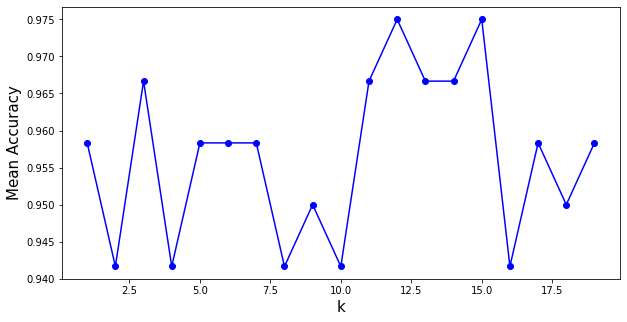

In [11]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

nkf = 10 # numero de folds
vk = [] # Vetor para guardar todos valores de k usados no modelo KNN
vscore = [] # Vetor para guardar todos os scores dos folds

# Para cada valor de "k", um modelo será criado e um "cross-validation" será realizado.
# Podemos ver os resultados obtidos para cada interacao desse loop.
for k in range(1, 20):
    model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    cv = cross_validate(model, x_train, y_train, cv=nkf)
    print('k:', k, 'Average accurace:', cv['test_score'].mean())
    vscore.append(cv['test_score'].mean())
    vk.append(k)

# Agora podemos escolher o melhor valor de k
best_k = np.argmax(vscore)+1
print('Melhor k:', best_k)
plt.figure(figsize=(10,5))
plt.plot(vk, vscore, '-bo')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Mean Accuracy', fontsize = 15)
plt.show()

Vamos usar o melhor valor de k para classificar os dados de teste.

In [12]:
from sklearn.metrics import accuracy_score
model = KNeighborsClassifier(n_neighbors=best_k, metric = 'euclidean')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Accuracy:', accuracy_score(y_pred, y_test))

Accuracy: 0.9666666666666667


Vamos repetir a classificação para a base de dados de câncer de mama.

In [13]:
import random
random.seed(1)
# Pandas é usado para manipulacao de dados
import pandas as pd
import matplotlib.pyplot as plt

# Leitura do arquivo CSV. Lembre de baixar os dados disponibilizados no site do MBA.
# Na mesma pasta que você está usando esse jupyter notebook, deve ser extraido os dados baixados.
# Note que ele entra na pasta "data" e abre o arquivo "BreastCancer.csv". Então você deve ter essa configuração na pasta que está o seu jupyter notebook
data = pd.read_csv('data/BreastCancer.csv', header=(0))
data = data.dropna(axis='rows') # Remove valores nulos
print(data.shape)
data.head(25)

(683, 11)


,Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,0
1,1002945,5,4,4,5,7,10.0,3,2,1,0
2,1015425,3,1,1,1,2,2.0,3,1,1,0
3,1016277,6,8,8,1,3,4.0,3,7,1,0
4,1017023,4,1,1,3,2,1.0,3,1,1,0
5,1017122,8,10,10,8,7,10.0,9,7,1,1
6,1018099,1,1,1,1,2,10.0,3,1,1,0
7,1018561,2,1,2,1,2,1.0,3,1,1,0
8,1033078,2,1,1,1,2,1.0,1,1,5,0
9,1033078,4,2,1,1,2,1.0,2,1,1,0


Convertemos para o formato de arrays do numpy para facilitar o acesso aos dados.

In [14]:
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

Selecionamos os conjuntos de teste e treinamento.

In [15]:
from sklearn.model_selection import train_test_split

p = 0.2 # fracao de elementos no conjunto de teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p)

Vamos fazer a validação cruzada.

k: 1 accurace: 0.6061279461279462
k: 2 accurace: 0.6575757575757577
k: 3 accurace: 0.6154545454545455
k: 4 accurace: 0.6447811447811447
k: 5 accurace: 0.6135690235690234
k: 6 accurace: 0.6593602693602694
k: 7 accurace: 0.6262962962962962
k: 8 accurace: 0.6374074074074074
k: 9 accurace: 0.6593602693602694
k: 10 accurace: 0.6556228956228957
k: 11 accurace: 0.6556565656565656
k: 12 accurace: 0.6721548821548822
k: 13 accurace: 0.6665656565656566
k: 14 accurace: 0.6722222222222223
k: 15 accurace: 0.6648821548821549
k: 16 accurace: 0.6703367003367002
k: 17 accurace: 0.6758585858585858
k: 18 accurace: 0.6795286195286195
k: 19 accurace: 0.6795959595959596
k: 20 accurace: 0.6850841750841751
k: 21 accurace: 0.6832659932659932
k: 22 accurace: 0.6777777777777778
k: 23 accurace: 0.674107744107744
k: 24 accurace: 0.6831986531986532
k: 25 accurace: 0.6759595959595959
k: 26 accurace: 0.6814141414141414
k: 27 accurace: 0.6777777777777778
k: 28 accurace: 0.6796296296296297
k: 29 accurace: 0.677845117845

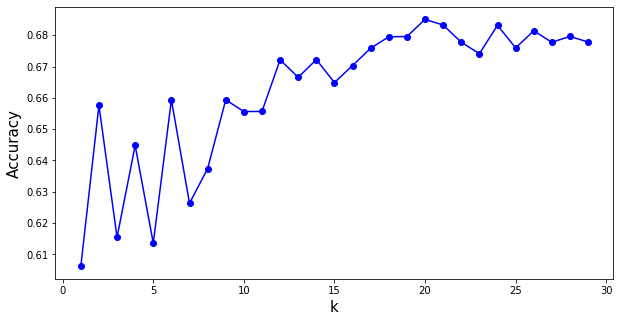

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

nkf = 10
vk = []
vscore = []
for k in range(1, 30):
    model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    cv = cross_validate(model, x_train, y_train, cv=nkf)
    print('k:', k, 'accurace:', cv['test_score'].mean())
    vscore.append(cv['test_score'].mean())
    vk.append(k)

best_k = np.argmax(vscore)+1
print('Melhor k:', best_k)
plt.figure(figsize=(10,5))
plt.plot(vk, vscore, '-bo')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show()

Aplicando ao conjunto de teste, podemos agora realizara classificação, usando todo o conjunto de treinamento na classificação.

In [17]:
from sklearn.metrics import accuracy_score
model = KNeighborsClassifier(n_neighbors=best_k, metric = 'euclidean')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Accuracy:', accuracy_score(y_pred, y_test))

Accuracy: 0.6423357664233577


### Exercícios de fixação

Não é necessário entregar os exercícios abaixo, mas é importante resolvê-los para fixar os conteúdos estudados. 

A solução dos exercícios de fixação serão postados durante a semana

1 - Para um polinômio de grau $M=9$, avalie como o erro se comporta quando aumentamos o tamanho do conjunto de treinamento. Considere N=10 até 1000. Ou seja, faça um gráfico de N versus o erro quadrático médio (RMSE).

2 - Troque a função seno por $x^6$ nos exemplos acima e realize a mesma análise apresentada nessa aula.

3 - Verifique como a acurácia muda em função do número de grupos k na validação cruzada, conforme feito acima, para a base de dados Vehicle.

4 - Varie o número de folds para a base iris, de 2 até 20 e verifique se essa escolha influencia na classificação.